In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import os
import pickle

# Functions

In [2]:
def lorentzian_components(params_gr, t):

    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')
    # freq  = np.linspace(1.0/Ttot, 1./2/dt, len(t)) # Hz

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    
    #VPSD /= 1e6     # units of VPSD is (m/s)**2/Hz
    VPSD *= (freq[-1] - freq[0])
           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    #print(len(phase), len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_regular_data_H0(params_gr, params_act, t):
    
    '''
    Inputs:
    - params_gr:= 
            see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - t = time (days)
        - y = RV (m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ts    = t*24*3600 # seconds
    ygr = lorentzian_components(params_gr, ts)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    amp, gam, logP, met  = params_act
    k  = kernels.ExpSine2Kernel(gamma=gam, log_period=logP)
    k *= kernels.ExpSquaredKernel(metric=met) # metric correspondind to r^2/lambda  is 1
    k *= amp**2 
    # print(k.get_parameter_vector())
    
    gp = george.GP(k)

    # generate synthetic dataset
    yact = gp.sample(t)
    
    # =========================================================================
    # Generate the intrincsic errors
    eb = np.random.normal(loc=3,scale=0.30, size=len(t)) # m/s
    if (any(eb < 0)) : eb = np.where(eb<0, 1.5, eb)
    yerr = np.random.normal(loc=0, scale=eb, size=len(t)) # this has to be defined according to the paper
    #print('std(yerr) = %f m/s'%np.std(yerr))

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors 
    ytot = ygr + yact + yerr * np.random.randn(len(t))
    
    #return ygr,yact, yerr* np.random.randn(N)
    return ytot, eb




def generate_planete(params_pl,t):
    """
    - params_pl
            - Ppl (Orbital period)
            - K (semi-amplitude)
            - T0 ( Phase à l'origine)
    """
    Ppl, K, T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)



def print_4periodogramme(LS,label,freq_pl):
    f1,f2,f3,f4 = freq_pl[:]
    l1,l2,l3,l4 = label[:]
    
    plt.figure()
    plt.suptitle("4 Lomb-Scargle peridogramme generated by removing the best fit\n")
    plt.subplot(411),plt.plot(freq, LS[:,0] , label =l1), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,0]),max(LS[:,0])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,0]),max(LS[:,0])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,0]),max(LS[:,0])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,0]),max(LS[:,0])],'y--')

    plt.subplot(412), plt.plot(freq, LS[:,1] , label =l2), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,1]),max(LS[:,1])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,1]),max(LS[:,1])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,1]),max(LS[:,1])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,1]),max(LS[:,1])],'y--')

    plt.subplot(413), plt.plot(freq, LS[:,2] , label =l3), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,2]),max(LS[:,2])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,2]),max(LS[:,2])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,2]),max(LS[:,2])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,2]),max(LS[:,2])],'y--')

    plt.subplot(414 ), plt.plot(freq, LS[:,3] , label = l4), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,3]),max(LS[:,3])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,3]),max(LS[:,3])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,3]),max(LS[:,3])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,3]),max(LS[:,3])],'y--')
    
    plt.xlabel("Frequency (day⁻¹)")
    plt.ylabel("Power")
    

def generate_4_periodogrammes(t,f, y, freq_pl,nbr_planete,eb):
    """
    Parameters
    ----------
    t : time (day)
    f : frequency ( day⁻1)
    y : original time serie

    Returns
    -------
    4 times series with their lomb-scargle 
    """
    y_t = np.zeros((len(t), 4)) #time series
    LS  = np.zeros((len(f), 4)) # 4 lombscargle 
    nbr_planete_now = np.copy(nbr_planete)
    label= np.zeros(4) #(1 if max = freq_pl, 0 else)
    max_value = np.zeros((2,4)) # (argmax, max)
    
    y_t[:,0] = np.copy(y)
    
    for i in range(3):
        LS_i =  LombScargle(t, y_t[:,i],eb)
        LS[:,i] = LS_i.power(f,method='cython')
        best_freq = f[np.argmax(LS[:,i])]
        #print("meilleur fit : ",best_freq)
        max_value[0,i], max_value[1,i] = best_freq, np.max(LS[:,i]) 
                
        if ( any(np.isclose(freq_pl, best_freq, atol=0.002)) ):
            label[i] = 1
            freq_pl[ np.where( np.isclose(freq_pl, best_freq, atol=0.002) ) ] = 0
            nbr_planete_now[i+1:] = nbr_planete_now[i] - 1
        else:
            label[i] = 0
            
        y_fit = LS_i.model(t,best_freq)
        y_t[:,i+1] = y_t[:,i] - y_fit
      
    LS_i = LombScargle(t, y_t[:,3],eb)
    LS[:,3] = LS_i.power(f,method='cython')
    best_freq = f[np.argmax(LS[:,3])]
    #print("meilleur fit : ",best_freq)
    max_value [0,3], max_value[1,3] =  best_freq, np.max(LS[:,3])
    
    if (any(np.isclose(freq_pl, best_freq, atol=0.002))):
        label[3] = 1
        freq_pl[np.where( np.isclose(freq_pl, best_freq, atol=0.002) )] = 0
    else:
        label[3] = 0
    
    #print("label = ", label)
    
    return LS, label, max_value, nbr_planete_now     



def generate_data(t,dt,Ttot,freq,params_gr, nbr_pl_to_inject):
    
    """
    Create a time series with nbr_pl_to_inject and his Lomb scargle periodogramme. 
    3 others times series are generated by removing a sin function corresponding to the max amplitude found
    in the periodogramme. So 4 Lomb-Scargle periodogrammes are generated.
    For each periodogramme, position and max amplitude are taken and a label is 
    created, either 1 or 0 if max amplitude correspond to a frequency planeteray signal.
    """
    
    LS = np.zeros((len(freq),4))
    freq_pl = np.zeros(4)
    nbr_planete = np.zeros(4)
    label = np.zeros((4))
    max_value = np.zeros((2,4))
    
    Prot = random.randint(5,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper
    amp  = gamma.rvs(2.0, 0.5) 
    epsilon = uniform.rvs(0.5, 1)
    tau = np.random.normal(3*Prot, 0.1*Prot) 
    gam  = 2.0/epsilon #not change
    logP = np.log(Prot) #not change 
    met  = 1.0 # not change 
    params_act = [amp, gam, logP, met]
    
    y_noise, eb = generate_regular_data_H0(params_gr, params_act, t)
    
    if ( nbr_pl_to_inject == 0): 
        LS[:,:], label[:], max_value[:,:],nbr_planete[:] = generate_4_periodogrammes(t, freq, y_noise, np.copy(freq_pl[:]),nbr_planete[:],eb) #Without planet
    
    else :
        y_i = y_noise
        for i in range(1,nbr_pl_to_inject+1):
            Ppl =  random.uniform(10*dt,Ttot/2) 
            K = loguniform.rvs(0.1, 10)
            T0 =  random.uniform(0,Ppl)
            params_pl = [Ppl,K,T0]
            freq_pl[i-1] = 1/Ppl
            
            y_pl = generate_planete(params_pl, t)
            y_i += y_pl 
        
        
        nbr_planete[:] = i
        #print("freq planet : ",freq_pl[i,:])
        LS[:,:], label[:], max_value[:,:],nbr_planete[:] = generate_4_periodogrammes(t, freq, y_i,np.copy(freq_pl[:]),nbr_planete[:],eb)
        
        
    return LS, label, max_value, freq_pl,nbr_planete


In [47]:
#Function to create the first dataset
def create_set1(nb_periodogramme, pourcentage_positif,t, dt, Ttot, freq):
    
    count_positif = 0
    count_negatif = 0
    nb_ech = nb_periodogramme/5
    count_ech = np.zeros(5)
    
    X_LS = []
    X_max_values = []
    Y = []
    
    start = time.time()
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #Create negatif label
    print("Create negatif label")
    #Create H0 data
    while( count_ech[0] < nb_ech):
        LS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, 0)
        for i in range(0,4):
            X_LS.append(LS[:,i])
            X_max_values.append(max_value[:,i])
            Y.append(label[i])
            count_ech[0] += 1
            count_negatif += 1
    print(count_ech)
    
    #Create planetary signal with negatif label
    nb_with_planete_negatif_label = (((1-pourcentage_positif) -1/5)*nb_periodogramme)/4
    for k in range(4,0,-1):
        while( count_ech[k] < nb_with_planete_negatif_label):
            LS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, k)
            for i in range(0,4):
                if ( (label[i] == 0) and (count_ech[round(nbr_planete[i])]<nb_with_planete_negatif_label) ):
                    X_LS.append(LS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech[round(nbr_planete[i])] += 1
                    count_negatif += 1
        print(count_ech)
    
    print("Create positif label")
    #Create positif label
    for k in range(4,0,-1):
        while( count_ech[k] < nb_ech):
            LS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, k)
            for i in range(0,4):
                if ( label[i] == 1 and (count_ech[round(nbr_planete[i])]<nb_ech) ):
                    X_LS.append(LS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech[round(nbr_planete[i])] += 1
                    count_positif += 1
        print(count_ech)
    
    print("Nbr de data = ",len(Y))
    print("Total time : ", time.time() - start, " s")
    print("Rapport negatif label = ", Y.count(0)/len(Y))
    return X_LS, X_max_values, Y

In [96]:
#Function to create the second dataset
def create_set(nb_periodogramme,t, dt, Ttot, freq):
    
    count_negatif = 0
    nb_ech = nb_periodogramme/5
    count_ech = np.zeros(5)
    
    X_LS = []
    X_max_values = []
    Y = []
    
    start = time.time()
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #Create H0 data
    while( count_ech[0] < nb_ech):
        LS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, 0)
        for i in range(0,4):
            X_LS.append(LS[:,i])
            X_max_values.append(max_value[:,i])
            Y.append(label[i])
            count_ech[0] += 1
            count_negatif += 1
    print(count_ech)
    
    #Create planetary signal 
    for k in range(4,0,-1):
        while( count_ech[k] < nb_ech):
            LS, label, max_value, freq_pl,nbr_planete = generate_data(t,dt,Ttot,freq,params_gr, k)
            for i in range(0,4):
                if ( count_ech[round(nbr_planete[i])]<nb_ech):
                    X_LS.append(LS[:,i])
                    X_max_values.append(max_value[:,i])
                    Y.append(label[i])
                    count_ech[round(nbr_planete[i])] += 1
                    if ( label[i] == 0) : count_negatif += 1
        print(count_ech)
        
    print("Nbr de data = ",len(Y))
    print("Total time : ", time.time() - start, " s")
    print("Rapport negatif label = ", count_negatif/len(Y), "ou", Y.count(0)/len(Y))
    
    return X_LS, X_max_values, Y

# Call functions to create dataset

In [49]:
#Generate time and frequency
#Over-sampling
Ttot = 200 # days
facteur_surech = 10
N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
t_over = np.linspace(0,Ttot,N) #days


# Irregular sampling 1 : with normal distribution
facteur_ech = 20
t = np.zeros(Ttot)

ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[0] = t_over[ ind0 ]
ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[-1] = t_over[ ind_fin ]

pas = N/Ttot
for i in range(Ttot-2):
    ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
    t[i+1] =  t_over[ind]

dt = np.median(np.diff(t))
fmin = 1/(t[-1]-t[0])
fmax = (1/dt)/2 
freq = np.linspace(fmin,fmax,990)

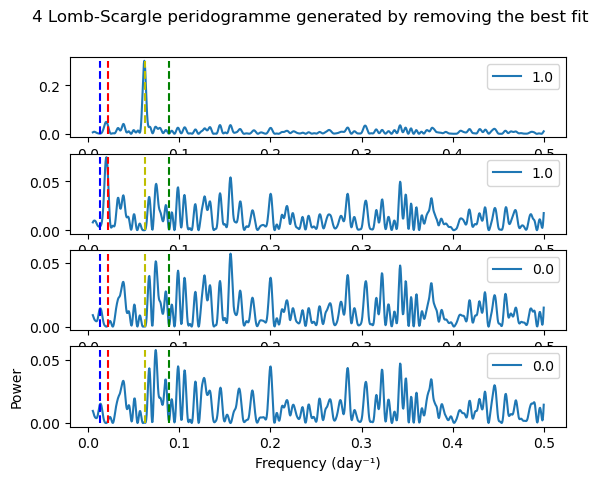

In [50]:
A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1*6 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz
params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]

LS, label, max_value, freq_pl, nb_planete = generate_data(t, dt, Ttot, freq, params_gr, 4)
print_4periodogramme(LS,label,freq_pl)

In [88]:
#create set 1
nbr_periodogramme_set1 = 13700
pourcentage_positive = 0.5
X_LS, X_max_values, Y = create_set1(nbr_periodogramme_set1,pourcentage_positive,t, dt, Ttot, freq)

Create negatif label
[2740.    0.    0.    0.    0.]
[2740.  277. 1028. 1028. 1028.]
[2740.  277. 1028. 1028. 1028.]
[2740.  277. 1028. 1028. 1028.]
[2740. 1028. 1028. 1028. 1028.]
Create positif label
[2740. 1037. 1220. 2003. 2740.]
[2740. 1072. 1523. 2740. 2740.]
[2740. 1338. 2740. 2740. 2740.]
[2740. 2740. 2740. 2740. 2740.]
Nbr de data =  13700
Total time :  679.2236807346344  s
Rapport negatif label =  0.5001459854014598


In [98]:
#Save dataset 1
np.save('./data/set1/X_LS.npy', np.array(X_LS, dtype=object), allow_pickle=True)
np.save('./data/set1/X_max_values.npy', np.array(X_max_values, dtype=object), allow_pickle=True)
np.save('./data/set1/Y.npy', np.array(Y, dtype=object), allow_pickle=True)
np.save('./data/set1/Freq.npy',  np.array(freq, dtype=object), allow_pickle=True)

In [97]:
#Create set 2
nbr_periodogramme_set2 = 1000
X_LS2, X_max_values2, Y2 = create_set(nbr_periodogramme_set2, t, dt, Ttot, freq)

[200.   0.   0.   0.   0.]
[200.  18. 149. 200. 200.]
[200.  18. 149. 200. 200.]
[200.  59. 200. 200. 200.]
[200. 200. 200. 200. 200.]
Nbr de data =  1000
Total time :  16.892192840576172  s
Rapport negatif label =  0.716 ou 0.716


In [95]:
#Save dataset 2
np.save('./data/set2/X_LS.npy', np.array(X_LS2, dtype=object), allow_pickle=True)
np.save('./data/set2/X_max_values.npy', np.array(X_max_values2, dtype=object), allow_pickle=True)
np.save('./data/set2/Y.npy', np.array(Y2, dtype=object), allow_pickle=True)

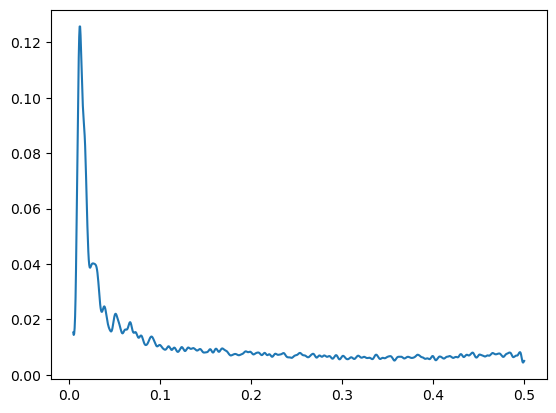

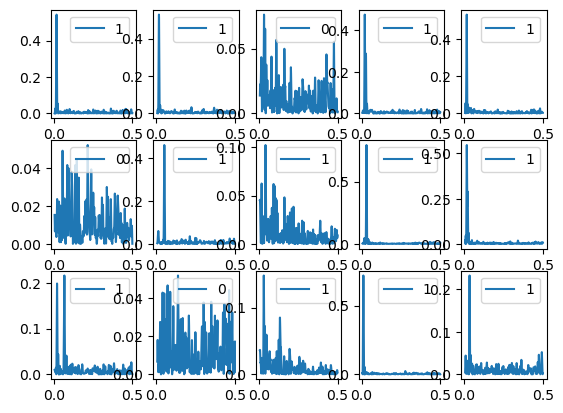

In [98]:
#Analyse dataset2
nb_planet = 4

#mean LS
indice = np.where( np.array(Nbr_planets) == nb_planet)
LS_pl = np.array(X_LS2)[indice]
Y_pl = np.array(Y2)[indice]
LS_mean = np.mean(LS_pl, axis=0)

#Print mean LS
plt.figure()
plt.plot(freq, LS_mean)

#Print LS
plt.figure()
k = 1
for i in range(3):
    for j in range(5):
        ind = random.randint(0,(nbr_periodogramme_set2/5)-1)
        plt.subplot(3,5,k), plt.plot(freq, LS_pl[ind], label = round(Y_pl[ind])), plt.legend()
        k+=1

# Test sous H0

In [109]:
A1, A2, A3  = 0.027, 0.003, 0.3*1e-3 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz

params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]



Y_gr = []
Y_act = []
Yerr = []

ls_gr = []
ls_act = []
ls_err = []

for i in range(1000):
    
    Prot = random.randint(10,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

    amp  = gamma.rvs(2.0, 0.5) 
    epsilon = uniform.rvs(0.5, 1)
    tau = np.random.normal(3*Prot, 0.1*Prot)         
    gam  = 2.0/epsilon #not change
    logP = np.log(Prot) #not change 
    met  = 1.0 # not change 

    params_act = [amp, gam, logP, met]
    
    ygr, yact, yerr = generate_regular_data_H0(params_gr, params_act, len(t), t)
    Y_gr.append(ygr)
    Y_act.append(yact)
    Yerr.append(yerr)
    ls_gr.append(LombScargle(t, ygr).power(freq, method = 'cython') )
    ls_act.append(LombScargle(t, yact).power(freq, method = 'cython') )
    ls_err.append(LombScargle(t, yerr).power(freq, method = 'cython'))
    
y_gr_moy = np.mean(Y_gr, axis =0)
ls_gr_moy = np.mean(ls_gr, axis = 0)

y_act_moy = np.mean(Y_act, axis =0)
ls_act_moy = np.mean(ls_act, axis = 0)

yerr_moy = np.mean(Yerr, axis =0)
ls_err_moy = np.mean(ls_err, axis = 0)


(<Axes: >,
 <matplotlib.legend.Legend at 0x7fe21dca9150>)

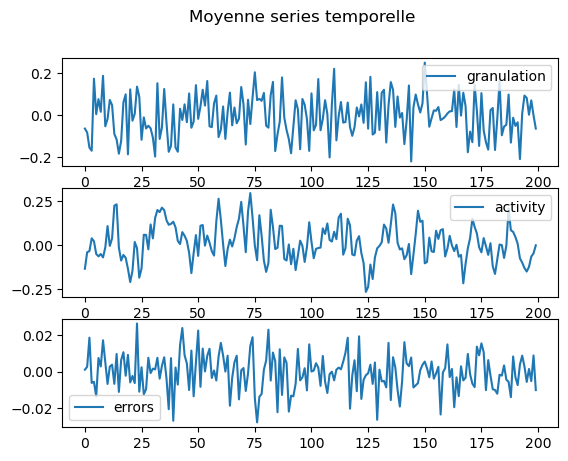

In [110]:
plt.suptitle("Moyenne series temporelle")
plt.subplot(311), plt.plot(y_gr_moy, label ='granulation'), plt.legend()
plt.subplot(312), plt.plot(y_act_moy, label='activity'), plt.legend()
plt.subplot(313), plt.plot(yerr_moy, label="errors"), plt.legend()

(<Axes: >,
 <matplotlib.legend.Legend at 0x7fe21da0ab90>)

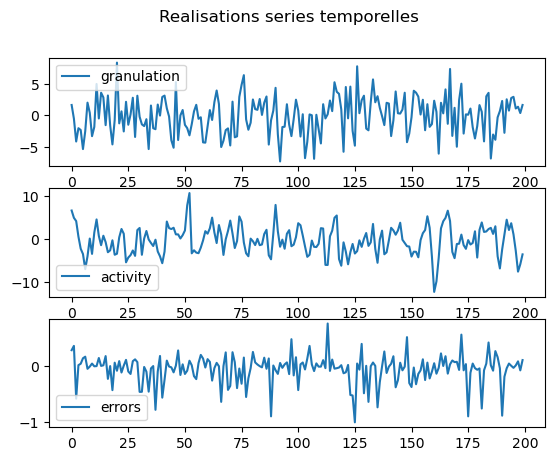

In [111]:
plt.suptitle("Realisations series temporelles")
plt.subplot(311), plt.plot(ygr, label ='granulation'), plt.legend()
plt.subplot(312), plt.plot(yact, label='activity'), plt.legend()
plt.subplot(313), plt.plot(yerr, label="errors"), plt.legend()

(<Axes: >,
 <matplotlib.legend.Legend at 0x7fe21d95ab30>)

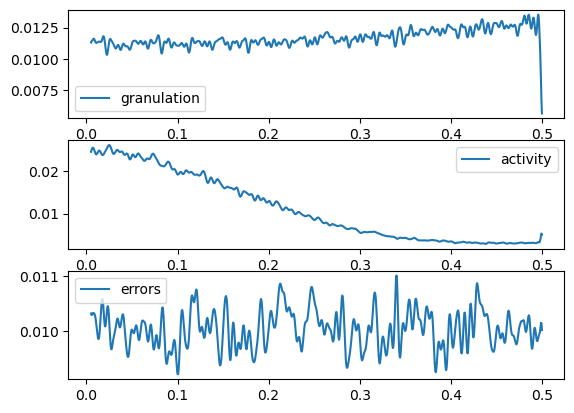

In [112]:
plt.suptitle("")
plt.subplot(311), plt.plot(freq,ls_gr_moy,label ='granulation'), plt.legend()
plt.subplot(312), plt.plot(freq,ls_act_moy, label='activity'), plt.legend()
plt.subplot(313), plt.plot(freq,ls_err_moy, label="errors"), plt.legend()

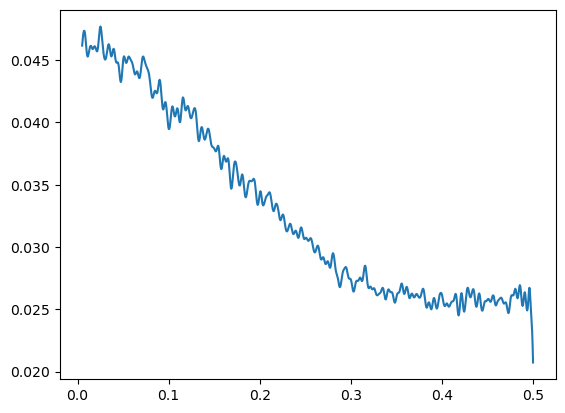

In [113]:
plt.plot(freq,ls_gr_moy + ls_act_moy +ls_err_moy)

# Basic test

(<Axes: >, <matplotlib.collections.PathCollection at 0x7fe21d04ece0>)

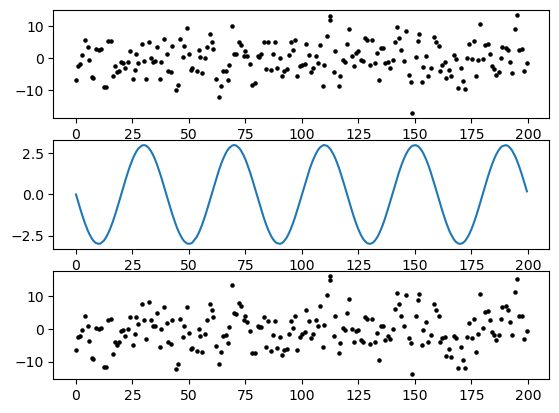

In [120]:
Ppl = 40
K = 3
T0 = 20
params_pl = Ppl, K, T0

ypl1 = generate_planete(params_pl, t)
ygr, yact, yerr = generate_regular_data_H0(params_gr, params_act, len(t), t)
y_noise = ygr + yact + yerr

ytot = y_noise + ypl1 + ypl2

plt.subplot(311), plt.scatter(t,y_noise, s = 5, c='k')
plt.subplot(312), plt.plot(t, ypl1)
plt.subplot(313), plt.scatter(t, ytot, s= 5, c='k')

(<Axes: >, [<matplotlib.lines.Line2D at 0x7fe21ce0b1c0>])

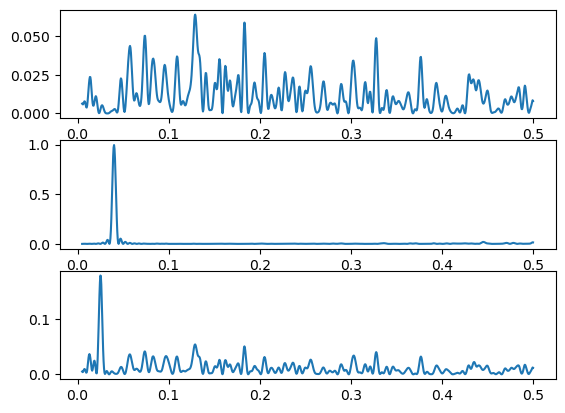

In [121]:
plt.subplot(311), plt.plot(freq, LombScargle(t,y_noise).power(freq,method='cython'))
plt.subplot(312), plt.plot(freq, LombScargle(t,ypl).power(freq,method='cython'))
plt.subplot(313), plt.plot(freq, LombScargle(t,ytot).power(freq,method='cython'))